In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/d_/wbvb32_j195786wh860dhd880000gn/T/ipykernel_58201/3081843450.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Read in election and demographic data
election_data = pd.read_csv("1976-2020-president.tab", sep = "\t")

In [3]:
demographic_data = pd.read_csv("demographics.csv")

In [4]:
# Filter the data based on year and votes
# Drop any duplicates
election_data_filtered = election_data.query("year == 2000 or year == 2004")
election_data_winner = election_data_filtered.sort_values('candidatevotes', ascending=False).drop_duplicates(['year', 'state'])

In [5]:
# Add demographic percentages to the demographic dataframe
demographic_data['perc_male'] = demographic_data['TOT_MALE'] / demographic_data['TOT_POP'] * 100
demographic_data['perc_female'] = demographic_data['TOT_FEMALE'] / demographic_data['TOT_POP'] * 100
demographic_data['perc_white'] = (demographic_data['WA_MALE'] + demographic_data['WA_FEMALE']) / demographic_data['TOT_POP'] * 100
demographic_data['perc_black'] = demographic_data['Black'] / demographic_data['TOT_POP'] * 100
demographic_data['perc_hispanic'] = demographic_data['Hispanic'] / demographic_data['TOT_POP'] * 100

In [6]:
# Simplify the election data
election_data_simplified = election_data_winner[['year', 'state', 'party_detailed']]
election_data_simplified.head()

,year,state,party_detailed
2432,2004,CALIFORNIA,DEMOCRAT
2069,2000,CALIFORNIA,DEMOCRAT
2678,2004,TEXAS,REPUBLICAN
2615,2004,NEW YORK,DEMOCRAT
2472,2004,FLORIDA,REPUBLICAN


In [7]:
# Simplify the demographic data and rename the state column to prep for merge
demographic_data_simplified = demographic_data[['STNAME', 'perc_male', 'perc_female', 'perc_white', 'perc_black', 'perc_hispanic']]
demographic_data_simplified = demographic_data_simplified.rename(columns={"STNAME": "state"})

In [8]:
# Prep state for merge
election_data_simplified.loc[:,'state'] = election_data_simplified['state'].str.upper()
demographic_data_simplified.loc[:,'state'] = demographic_data_simplified['state'].str.upper()

In [9]:
# merge the two dataframes
merged_df = pd.merge(election_data_simplified, demographic_data_simplified, how='left', left_on='state', right_on='state')

In [10]:
# Sort df alpha by state
merged_df.sort_values(by = 'state', inplace = True)

In [11]:
# Replace the DFL party with Dem
merged_df['party_detailed'] = merged_df['party_detailed'].replace({'DEMOCRATIC-FARMER-LABOR': 'DEMOCRAT'})

In [12]:
# Create df for only 2000 data
df_2000 = merged_df[merged_df['year'] == 2000]

In [13]:
# Create df for only 2004 data
df_2004 = merged_df[merged_df['year'] == 2004]

In [14]:
# Prepare X and Y df to find best K values
X_2000 = df_2000.drop(['state', 'party_detailed', 'year'], axis=1)
y_2000 = df_2000['party_detailed']

In [15]:
# Make Dem/Repub binary where R is 1 and D is 0
y_2000 = y_2000.map({'DEMOCRAT': 0, 'REPUBLICAN': 1})

In [16]:
def find_best_k_for_metric(X, y, metric, k_range, higher_is_better=True):
    """
    Finds the best k value for KNeighborsClassifier based on a given metric.
    
    Parameters:
    - X: Features DataFrame.
    - y: Target Series.
    - metric: The scoring metric to use ('precision_macro', 'recall_macro', etc.).
    - k_range: Range of k values to test.
    - higher_is_better: Boolean indicating whether a higher score is better for the metric.
    
    Returns:
    - best_k: The k value that resulted in the best score.
    - best_score: The best score achieved.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    best_score = -np.inf if higher_is_better else np.inf
    best_k = None

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        cv_results = cross_validate(knn, X, y, cv=kf, scoring=metric)
        mean_score = np.mean(cv_results['test_score'])

        if higher_is_better and mean_score > best_score:
            best_score = mean_score
            best_k = k
        elif not higher_is_better and mean_score < best_score:
            best_score = mean_score
            best_k = k

    best_score_rounded = round(best_score, 4)
    
    return best_k, best_score_rounded

In [17]:
best_recall = find_best_k_for_metric(X_2000, y_2000, 'recall_macro', range(4, 11), higher_is_better = True)
print(f'The optimal K-value for recall is {best_recall[0]} with a score of {best_recall[1]}')

The optimal K-value for recall is 10 with a score of 0.4806


In [18]:
min_recall = find_best_k_for_metric(X_2000, y_2000, 'recall_macro', range(4, 11), higher_is_better = False)
print(f'The worst K-value for recall is {min_recall[0]} with a score of {min_recall[1]}')

The worst K-value for recall is 9 with a score of 0.3922


In [19]:
best_k_precision = find_best_k_for_metric(X_2000, y_2000, 'precision_macro', range(4, 11), higher_is_better = True)
print(f'The best K-value for overall precision is {best_k_precision[0]} with a score of {best_k_precision[1]}')

The best K-value for overall precision is 5 with a score of 0.5433


/Users/alex/opt/anaconda3/envs/ds2500/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
X_2004 = df_2004.drop(['state', 'party_detailed', 'year'], axis=1)

In [21]:
y_2004 = df_2004['party_detailed']
y_2004 = y_2004.map({'DEMOCRAT': 0, 'REPUBLICAN': 1})

In [22]:
# Create classifier for the 2004 data
optimal_k_for_precision = best_k_precision[0]
knn_2004 = KNeighborsClassifier(n_neighbors = optimal_k_for_precision)
X_train, X_test, y_train, y_test = train_test_split(X_2004, y_2004, random_state = 0) # Train test split
knn_2004.fit(X_train, y_train) # Training data

KNeighborsClassifier()

In [23]:
# Predict the 2004 election results using the test split
predictions_2004 = knn_2004.predict(X_test) # testing data (x_train)

In [24]:
f1_score_republican = f1_score(y_test, predictions_2004, average = 'binary', pos_label = 1, zero_division = 0)
print(f'The f1 score for states that voted Republican is {round(f1_score_republican, 2)}')

The f1 score for states that voted Republican is 0.74


In [25]:
correct_republican_predictions = ((predictions_2004 == 1) & (y_test == 1)).sum()
print(f'The model correctly predicted {correct_republican_predictions} states that voted Republican')

The model correctly predicted 7 states that voted Republican


In [26]:
def how_did_state_vote(df, state, test_data, predictions):
    ''' 
    Takes in a dataframe, state name, test data, and predictions

    Predicts how a state will vote for that year and validates the selection against the actual data for that year
    '''

    state_index = df[df['state'] == state].index[0]
    
    state_actual = test_data.iloc[state_index]
    state_predicted = predictions[state_index]
    
    if state_actual == state_predicted:
        print(f"The model correctly predicted {state}'s voting outcome in 2004.")
    else:
        print(f"The model did not correctly predict {state}'s voting outcome in 2004.")

In [27]:
how_did_state_vote(df_2004, 'OHIO', y_2004, predictions_2004)
print(f"F1 score for Republican states: {f1_score_republican: .4f}")
print(f"Number of states correctly predicted to vote Republican: {correct_republican_predictions}")

The model correctly predicted OHIO's voting outcome in 2004.
F1 score for Republican states:  0.7368
Number of states correctly predicted to vote Republican: 7


In [28]:
optimal_k_recall = find_best_k_for_metric(X_2004, y_2004, 'recall_macro', range(4,11), higher_is_better = True)

In [29]:
cm = confusion_matrix(y_test, predictions_2004)
cm_labels = ['Democrat', 'Republican']

In [30]:
def plot_heat_map(cm, cm_labels):
    '''
    Creates a heatmap of the confusion matrix with given labels
    '''
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'seismic', xticklabels = cm_labels, yticklabels = cm_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for 2004 Election Predictions')
    plt.show()

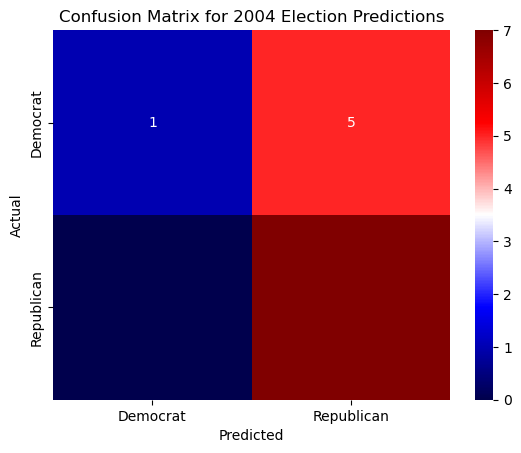

In [31]:
plot_heat_map(cm, cm_labels)

In [32]:
def metrics_list_generator(k_range, metric, X, y):
    '''
    Params:
        - List of K-Values
        - Required metric
        - X data
        - Y data
    Returns:
        - List of metrics for each value of K
    '''

    metrics = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        cv_results = cross_validate(knn, X, y, cv=kf, scoring=metric)
        mean_score = np.mean(cv_results['test_score'])
        metrics.append(mean_score)
        
    return metrics
        

In [33]:
import matplotlib.pyplot as plt

k_range = range(4, 11)
metrics_list = metrics_list_generator(k_range, 'precision_macro', X_2000, y_2000)

/Users/alex/opt/anaconda3/envs/ds2500/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
def find_max_metric(metrics_list, k_range):
    '''
    Params:
        - List of metrics
        - Range of K-Values
    Returns:
        - The optimal K-Value
        - The corresponding metric to go along with that value
    '''

    max_metric_index = np.argmax(metrics_list)
    k_list = list(k_range)
    max_k = k_list[max_metric_index]
    max_score = metrics_list[max_metric_index]

    return max_k, max_score

In [35]:
def plot_metrics(k_range, metrics_list):
    '''
    Params:
        - Range of k-values
        - Metrics list
    Returns:
        - A plot of all the K-Values and their metrics
        - The optimal metric as a star on the plot
    '''
   
    mxs = find_max_metric(metrics_list, k_range)
    
    plt.scatter(list(k_range), metrics_list, color = 'orange', label = 'Precision Scores')
    plt.scatter(mxs[0], mxs[1], marker = '*', label = 'Optimal Value', s = 200, color = 'dodgerblue')
    plt.title('Precision Scores for K-Values')
    plt.ylabel('Precision Scores')
    plt.xlabel('K_Value')
    plt.legend()
    plt.grid()
    plt.show()

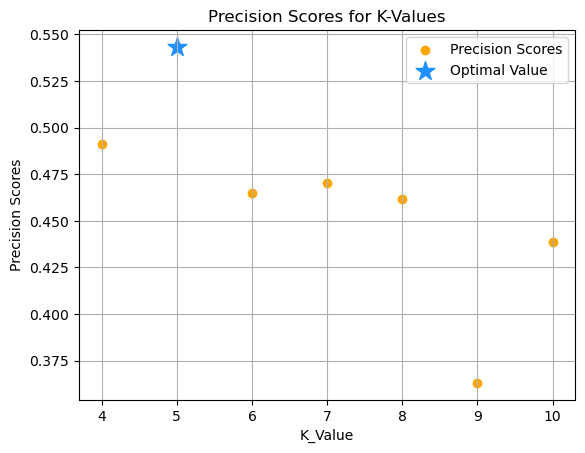

In [36]:
plot_metrics(k_range, metrics_list)